In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2

%matplotlib inline

In [2]:
# load data
data = pd.read_csv('../data/preprocessed/dataset_fixed.csv')
ranks = pd.read_csv('../data/rank_distr.csv')

In [3]:
data.describe()

,shots,shots_against,goals,goals_against,saves,assists,score,shooting_percentage,bpm,bcpm,...,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,inflicted,taken,tier
count,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,...,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000,404951.000000
mean,2.090967,6.300093,0.765426,2.322078,0.956138,0.470193,295.091181,31.676114,318.119289,329.919834,...,34.361202,71.789389,28.210611,34.711652,33.738777,33.705974,34.698521,0.632669,0.626666,14.749960
std,1.579105,3.109130,0.910271,1.618102,1.064952,0.693714,155.829024,38.585542,84.346060,86.524476,...,7.829006,6.083261,6.083261,7.945853,6.709148,6.054861,7.256317,0.968222,0.879370,4.551041
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.221877,0.072354,0.217817,0.291715,0.000000,0.000000,1.000000
25%,1.000000,4.000000,0.000000,1.000000,0.000000,0.000000,182.000000,0.000000,260.000000,271.790540,...,29.441245,68.046705,24.289200,29.570912,29.432397,29.950629,30.057923,0.000000,0.000000,11.000000
50%,2.000000,6.000000,1.000000,2.000000,1.000000,0.000000,278.000000,20.000000,325.000000,336.370400,...,34.427560,71.952700,28.047293,34.257595,33.475227,33.466953,34.267536,0.000000,0.000000,15.000000
75%,3.000000,8.000000,1.000000,3.000000,2.000000,1.000000,389.000000,50.000000,379.000000,391.368710,...,39.420711,75.710800,31.953294,39.251503,37.717817,37.139702,38.763768,1.000000,1.000000,19.000000
max,18.000000,39.000000,14.000000,33.000000,11.000000,8.000000,2129.000000,500.000000,816.000000,1446.428600,...,91.825775,100.000010,100.000000,114.739630,151.785720,126.785710,117.857150,43.000000,29.000000,22.000000


In [4]:
categorical = ['saves', 'mvp', 'goals', 'taken',
               'goals_against_while_last_defender', 'shots', 'inflicted', 'assists']
numerical = list(set(data.columns) - set(categorical) - {'tier'})
print(categorical)
print(numerical)

['saves', 'mvp', 'goals', 'taken', 'goals_against_while_last_defender', 'shots', 'inflicted', 'assists']
['time_high_air', 'amount_used_while_supersonic', 'percent_behind_ball', 'amount_stolen', 'avg_distance_to_ball', 'percent_most_forward', 'time_zero_boost', 'percent_defensive_half', 'percent_most_back', 'count_stolen_small', 'avg_speed', 'time_most_forward', 'amount_overfill_stolen', 'avg_distance_to_mates', 'time_low_air', 'time_boost_0_25', 'percent_supersonic_speed', 'percent_ground', 'time_full_boost', 'avg_powerslide_duration', 'time_closest_to_ball', 'score', 'time_boost_speed', 'goals_against', 'time_supersonic_speed', 'percent_offensive_third', 'time_most_back', 'percent_zero_boost', 'percent_boost_50_75', 'time_ground', 'count_collected_small', 'count_stolen_big', 'percent_closest_to_ball', 'time_neutral_third', 'percent_boost_25_50', 'time_slow_speed', 'percent_high_air', 'time_defensive_half', 'amount_stolen_small', 'percent_farthest_from_ball', 'percent_infront_ball', '

In [5]:
def calculate_plot_bar(data, name, value_name=None, rotation=0):
    labels, counts = np.unique(data[name], return_counts=True)
    labels = list(map(lambda x: str(x), labels))
    source = pd.DataFrame({name: labels, 'counts': counts})
    plot_bar(source, name, value_name=value_name, rotation=rotation)

def plot_bar(data, name, value_name=None, rotation=0):
    if value_name is None:
        value_name = 'counts'
    ax = sns.barplot(x=name, y=value_name, data=data)
    sns.set(rc={'figure.figsize':(15,15)})
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=rotation)
    plt.show()

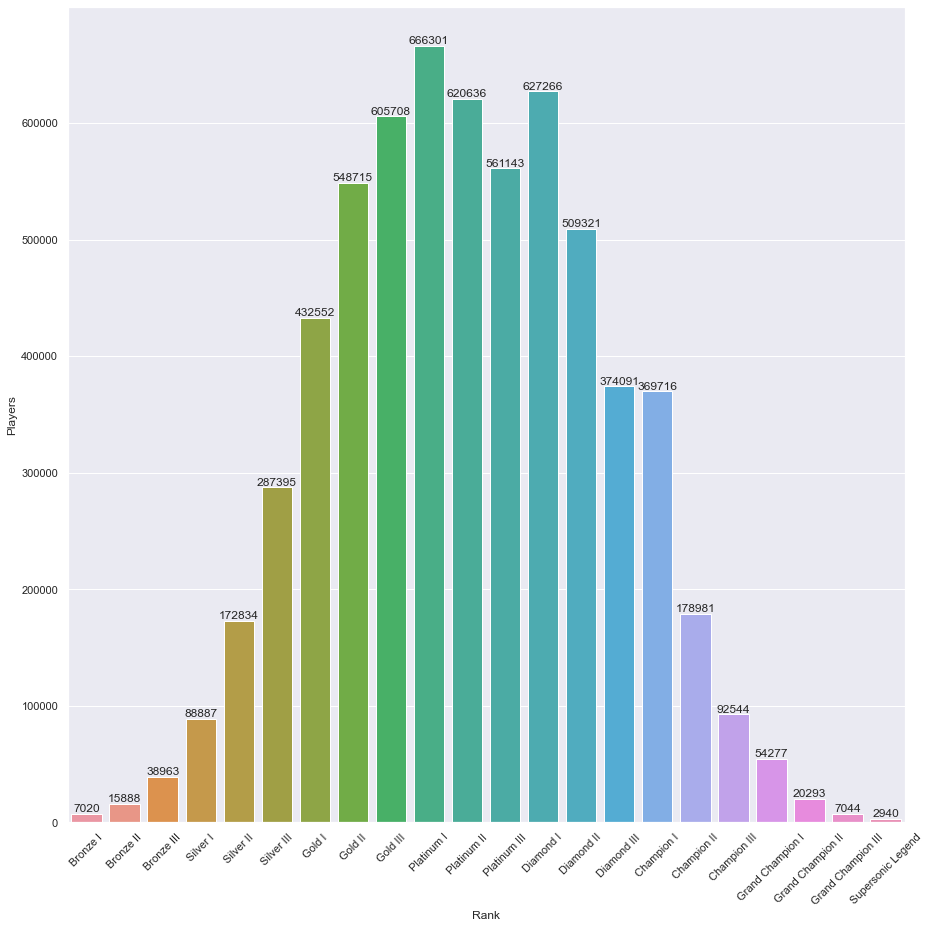

In [8]:
plot_bar(ranks, 'Rank', 'Players', 45)

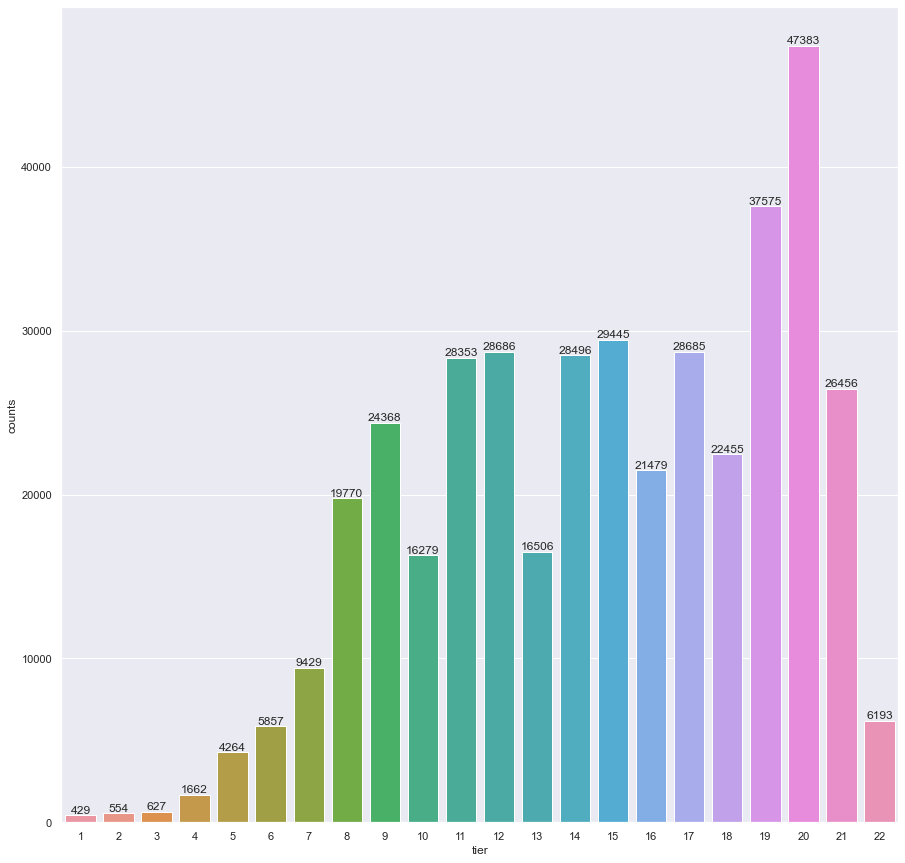

In [12]:
calculate_plot_bar(data, 'tier')

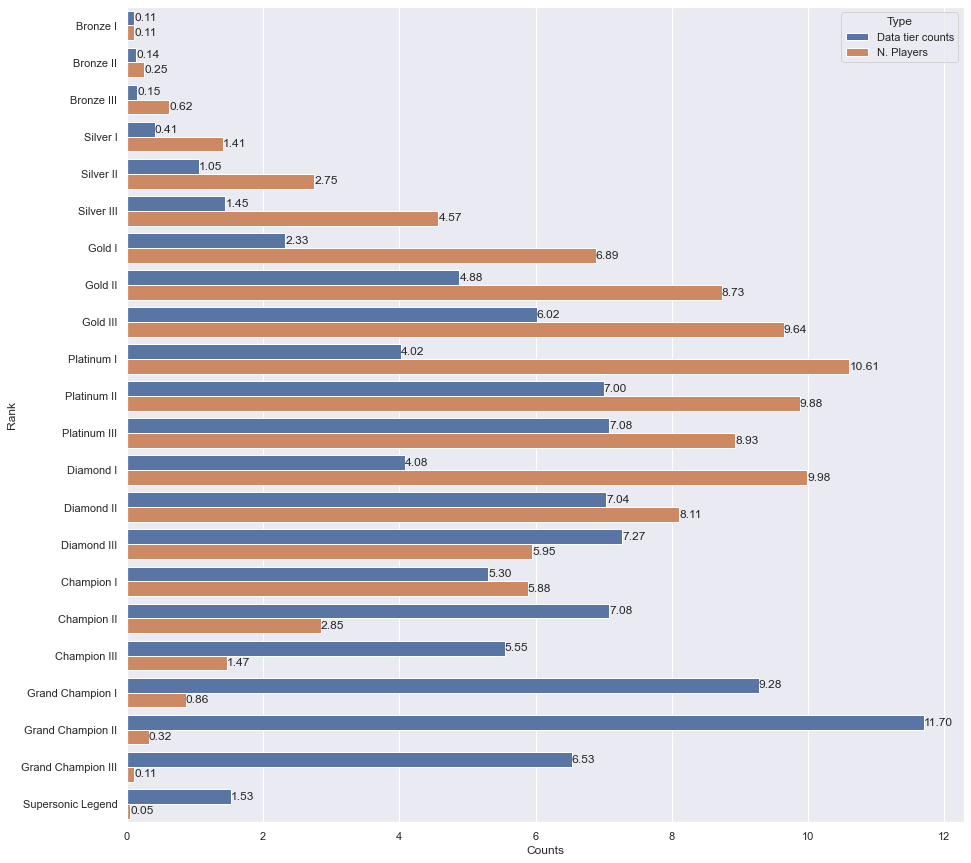

In [8]:
_, data_tier_counts = np.unique(data['tier'], return_counts=True)
player_counts_df = pd.DataFrame(
    {'Rank': ranks['Rank'],
     'Data tier counts': data_tier_counts / np.sum(data_tier_counts) * 100,
     'N. Players': ranks['Players'] / ranks['Players'].sum() * 100
     })
player_counts_df_melted = player_counts_df.melt(id_vars=['Rank'], value_vars=['Data tier counts', 'N. Players'], var_name='Type', value_name='Counts')
ax = sns.barplot(x='Counts', y='Rank', hue='Type', data=player_counts_df_melted, orient='h')
sns.set(rc={'figure.figsize':(15,15)})
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.bar_label(ax.containers[1], fmt='%.2f')
plt.savefig("../docs/res/imgs/tier2.pdf", format="pdf")
plt.show()

In [ ]:
for feature in categorical:
    calculate_plot_bar(data, feature)

In [ ]:
for feature in tqdm(numerical):
    sns.displot(data[feature], kde=True)
plt.show()

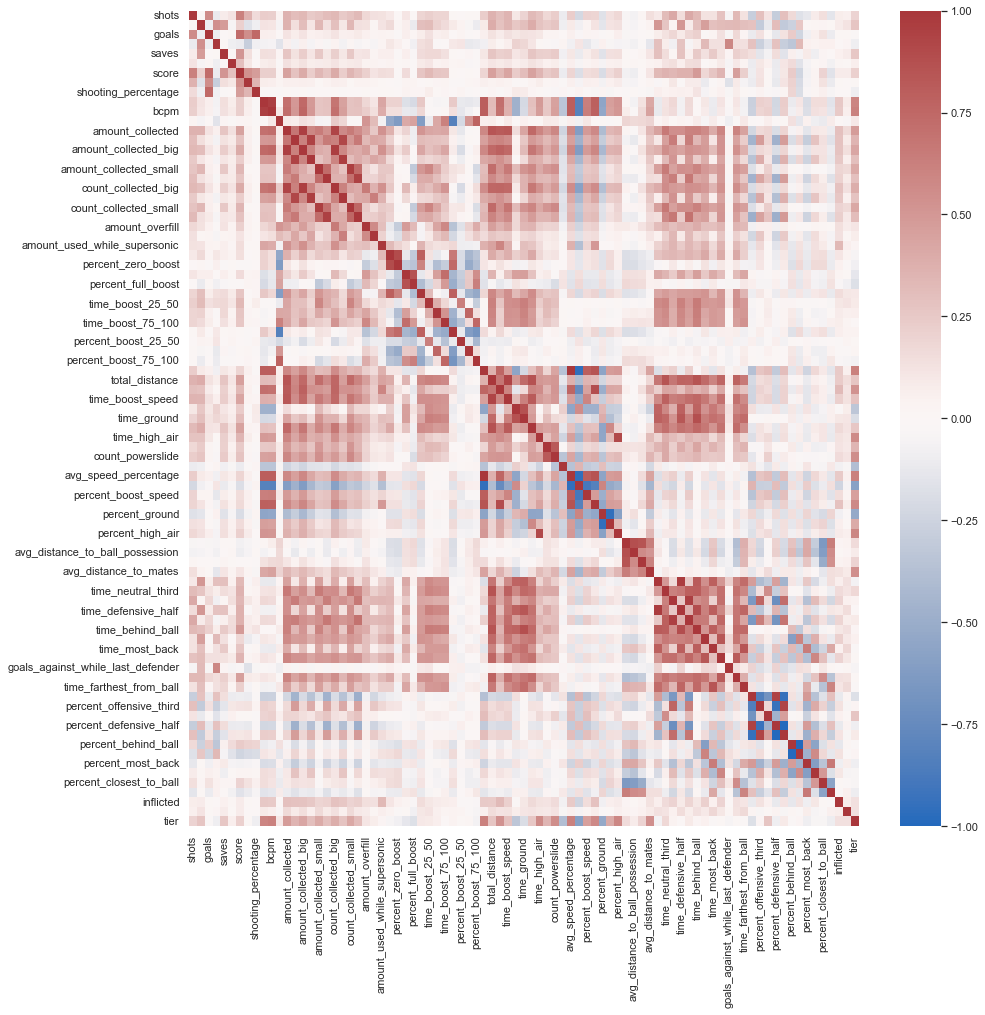

In [23]:
corr_matrix = data.corr()
fig = sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="vlag")
sns.set(rc={'figure.figsize':(15,15)})
plt.savefig("../docs/res/imgs/correlations.pdf", format="pdf")
plt.show()

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
    corr_matrix.values[[np.arange(len(corr_matrix))]*2] = np.nan
    corr_matrix = corr_matrix.where(mask)
    print(corr_matrix.stack().sort_values())

percent_defensive_half              percent_offensive_half               -1.000000
percent_behind_ball                 percent_infront_ball                 -1.000000
avg_speed                           percent_slow_speed                   -0.958380
avg_speed_percentage                percent_slow_speed                   -0.958380
percent_ground                      percent_low_air                      -0.957387
percent_defensive_third             percent_offensive_half               -0.945115
percent_offensive_third             percent_defensive_half               -0.936839
percent_slow_speed                  percent_boost_speed                  -0.889098
percent_defensive_third             percent_offensive_third              -0.837979
percent_slow_speed                  percent_supersonic_speed             -0.826471
avg_amount                          percent_boost_0_25                   -0.821354
bpm                                 percent_slow_speed                   -0.815448
bcpm

C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_21536\784889114.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_21536\784889114.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr_matrix.values[[np.arange(len(corr_matrix))]*2] = np.nan


In [41]:
correlated_features = [
    "time_offensive_half", # time_offensive_third
    "time_defensive_half", # time_defensive_third
    "time_infront_ball", #  time_behind_ball
    "time_behind_ball", # percent_infront_ball
    "time_ground", # time_low_air, time_high_air
    "time_slow_speed", # time_boost_speed, time_supersonic_speed
    "time_most_back", # time_most_forward
    "time_most_forward", # time_infront_ball

    "percent_defensive_half", # percent_offensive_half
    "percent_behind_ball", # percent_infront_ball
    "avg_speed", # percent_slow_speed
    "percent_ground", # percent_low_air, percent_high_air
    
    "time_farthest_from_ball",
    "percent_boost_75_100", # percent_boost
    "time_boost_0_25", # percent_boost
    "time_boost_25_50",
    "time_boost_50_75",
    "time_boost_75_100",
    "time_defensive_third", # percent_offensive_third
    "time_offensive_third", # percent_offensive_third
    "percent_offensive_half", # percent_offensive_third
    "percent_defensive_half", # percent_offensive_third
    "percent_defensive_third", # percent_offensive_third, percent_neutral_third
    "percent_slow_speed", # percent_boost_speed

    "avg_amount", # percent_boost
    "avg_speed_percentage", # avg_speed
    "time_defensive_half", # percent_defensive_half
    "time_offensive_half", # percent_offensive_half
    "count_collected_big", # amount_coellected_big
    "count_collected_small", # amount_coellected_small
    "count_stolen_big", # amount_stolen_big
    "count_stolen_small", # amount_stolen_small
    "time_low_air", # time_boost_speed
    "time_high_air", # percent_high_air
    "time_supersonic_speed", # percent_supersonic_speed
    "time_zero_boost", # percent_zero_boost
    "time_full_boost", # percent_full_boost
    "amount_stolen",  # amount_stolen_big
    "amount_collected", # amount_collected_big
    "avg_distance_to_ball", # avg_distance_to_ball_possession
    "total_distance", # time_boost_speed
    "time_powerslide", # count_powerslide
    "bcpm", # bpm
]
print(len(correlated_features))

43


In [42]:
data_uncorr = data.drop(columns=correlated_features)

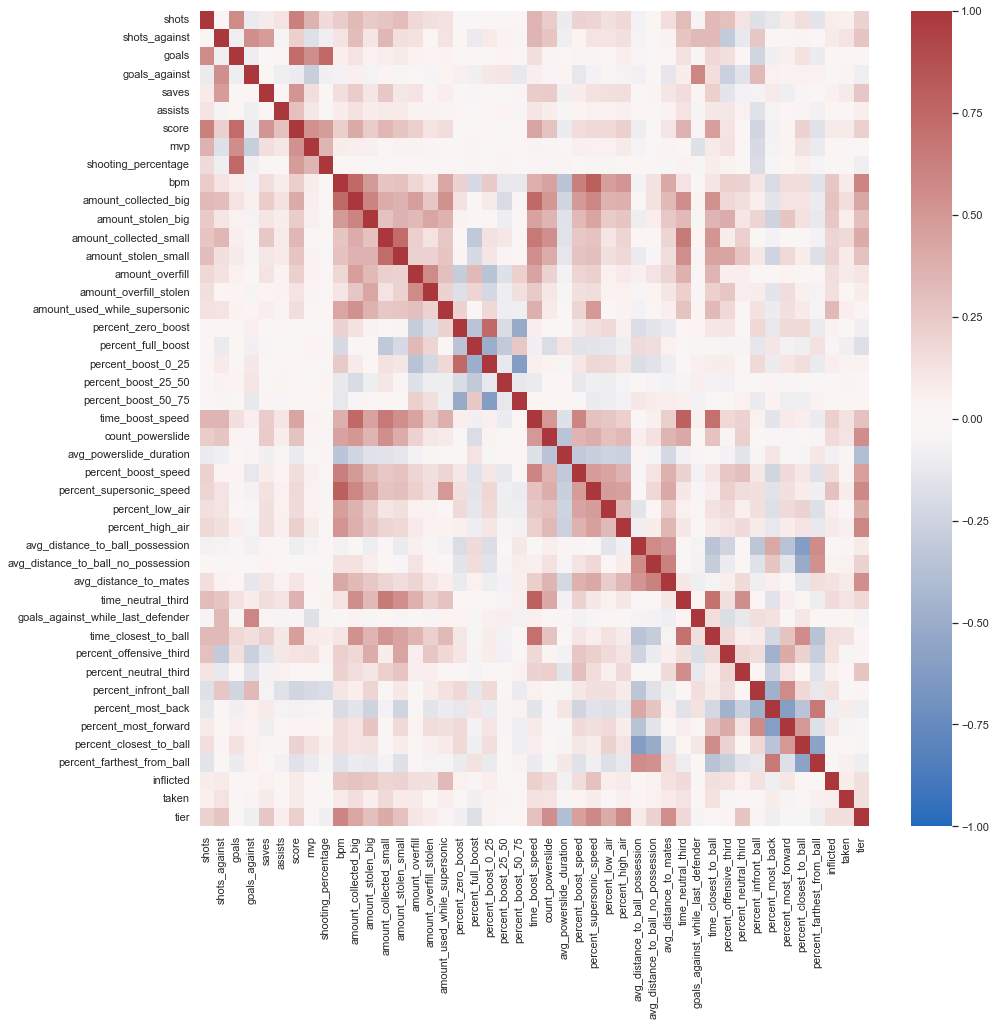

In [43]:
corr_matrix = data_uncorr.corr()
fig = sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="vlag")
sns.set(rc={'figure.figsize':(15,15)})
plt.show()

In [44]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
    corr_matrix.values[[np.arange(len(corr_matrix))]*2] = np.nan
    corr_matrix = corr_matrix.where(mask)
    print(corr_matrix.stack().sort_values())

percent_boost_0_25                  percent_boost_50_75                  -0.615876
avg_distance_to_ball_possession     percent_closest_to_ball              -0.613182
percent_most_back                   percent_most_forward                 -0.602500
percent_closest_to_ball             percent_farthest_from_ball           -0.574168
percent_zero_boost                  percent_boost_50_75                  -0.518029
avg_distance_to_ball_no_possession  percent_closest_to_ball              -0.513291
percent_full_boost                  percent_boost_0_25                   -0.498636
percent_infront_ball                percent_most_back                    -0.475073
percent_offensive_third             percent_most_back                    -0.467103
avg_powerslide_duration             tier                                 -0.388482
avg_distance_to_ball_possession     percent_most_forward                 -0.359237
amount_overfill                     percent_boost_0_25                   -0.356777
time

C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_21536\784889114.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones(corr_matrix.shape)).astype(np.bool)
C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_21536\784889114.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr_matrix.values[[np.arange(len(corr_matrix))]*2] = np.nan


In [45]:
# Information gain test
x_features = list(set(data_uncorr.columns) - {'tier'})
X = data_uncorr[x_features]
Y = data_uncorr['tier']
importances = mutual_info_classif(X, Y)
feat_importance = pd.Series(importances, X.columns)

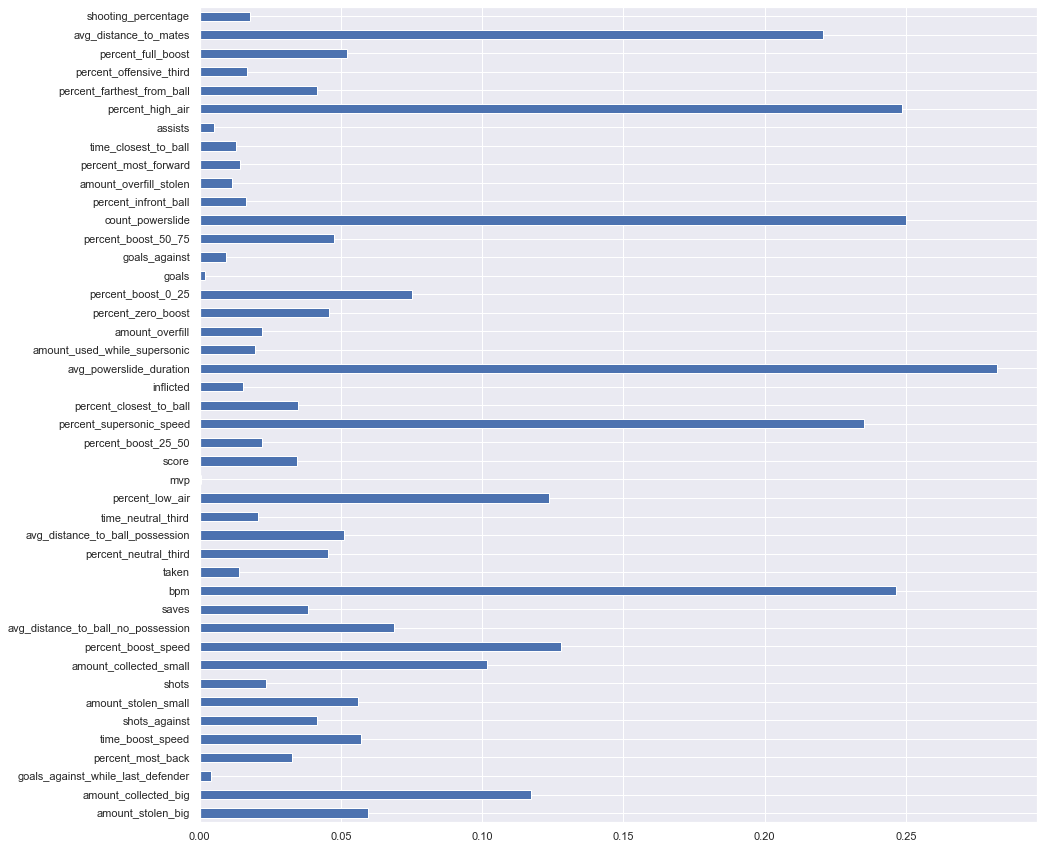

In [46]:
feat_importance.plot(kind='barh')
sns.set(rc={'figure.figsize':(15,15)})
plt.savefig("../docs/res/imgs/ig.pdf", format="pdf")
plt.show()

In [47]:
chi2_importances = chi2(X, Y)
chi2_feat_importance = pd.Series(importances, X.columns)

In [48]:
chi2_feat_importance[chi2_feat_importance < 0.01]

goals_against_while_last_defender    0.004186
mvp                                  0.000527
goals                                0.001745
goals_against                        0.009503
assists                              0.005049
dtype: float64

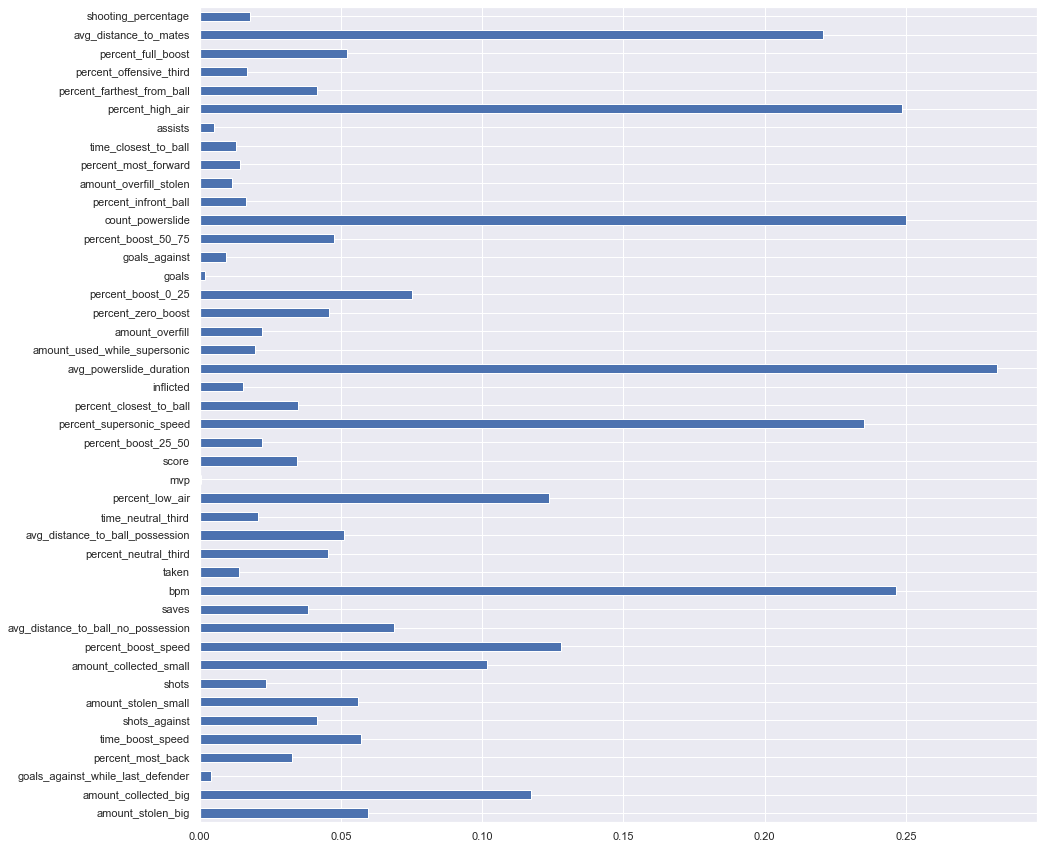

In [49]:
chi2_feat_importance.plot(kind='barh')
sns.set(rc={'figure.figsize':(15,15)})
plt.savefig("../docs/res/imgs/chi2.pdf", format="pdf")
plt.show()

In [50]:
uninformative_features = [
    'goals',
    'mvp',
    'assists',
    'goals_against_while_last_defender',
    'goals_against',
]

In [51]:
data_selected = data_uncorr.drop(columns=uninformative_features)
print(len(data_informative.columns))

42


In [52]:
data_selected.to_csv('../data/preprocessed/dataset_selected.csv', index=None)